In [279]:
import pandas as pd

In [321]:
data1 = pd.read_excel('features_vgg16_Tongi_session1_right_dataset.xlsx')

In [322]:
data1.columns

Index(['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6',
       'feature7', 'feature8', 'feature9', 'feature10',
       ...
       'feature4088', 'feature4089', 'feature4090', 'feature4091',
       'feature4092', 'feature4093', 'feature4094', 'feature4095',
       'feature4096', 'class'],
      dtype='object', length=4097)

In [323]:
data1['class'].unique().shape

(300,)

In [324]:

data= data1 # 310 

data_persons = len(data['class'].unique())
train_size,validate_size,test_size=int(data_persons*0.7), int(data_persons*.15), int(data_persons*.15)
train_data= data[data['class'].isin( list(range(1,train_size) ))]
validate_data= data[data['class'].isin( list(range(train_size,train_size+validate_size ) ))]
test_data= data[data['class'].isin( list(range(train_size+validate_size ,train_size+validate_size +test_size ) ))]

In [325]:
train_data.shape, validate_data.shape, test_data.shape

((2090, 4097), (450, 4097), (450, 4097))

In [326]:
features = list(data.columns)
features.remove('class')
print(features[-10:])

['feature4087', 'feature4088', 'feature4089', 'feature4090', 'feature4091', 'feature4092', 'feature4093', 'feature4094', 'feature4095', 'feature4096']


In [327]:
X_train = train_data[features]
y_train = train_data['class']

X_test = test_data[features]
y_test = test_data['class']


X_validate = validate_data[features]
y_validate = validate_data['class']


X_train.shape, X_test.shape


((2090, 4096), (450, 4096))

In [328]:
import numpy as np

In [329]:

def getMean(df, list_index, n):
    #print( list_index,n)
    selected_list_index = np.random.choice(list_index,n,replace=False)
    return df.iloc[selected_list_index].mean()
    

getMean(X_train, [1,2,3,4,5], 3).values

array([0.        , 1.17978223, 0.        , ..., 0.        , 1.20329253,
       0.73604059])

In [330]:
import numpy as np
np.random.seed(7)

def make_pairs(images, labels,No_images_avarage=1):
	# initialize two empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative
	pairImages = []
	pairLabels = []
	pairPersons= []
	images.reset_index(inplace=True, drop=True) 
	labels.reset_index(inplace=True, drop=True)
    
	# calculate the total number of classes present in the dataset
	# and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	# loop over all images
	counter = 0
	train_labels_pd = pd.DataFrame({'label': labels})
	parent_list=[]
	for idxA in range(len(images)):
		# grab the current image and label belonging to the current
		# iteration
		currentImage = images.iloc[idxA]
		#print(idxA)
		label = labels.iloc[idxA]
        #get indeces of images of same label 
		parent_list.append(idxA)
		indexes_same_label =list( train_labels_pd[train_labels_pd.label==label].index)
		indexes_same_label = list(set(indexes_same_label)-set(parent_list)) 
		indexes_diffrent_label =list( train_labels_pd[train_labels_pd.label!=label].index)

		for idxB in indexes_same_label: #loop over same label one by one
			if idxB !=idxA:
				#posImage = images.iloc[idxB]
				# this condition will prevent error when indexes_same_label become less than 3( p.random.choice gives error)
				if len(indexes_same_label)< No_images_avarage :  
					continue
				avarage_Image = getMean(images, indexes_same_label, No_images_avarage).values #use avarage of same class data  
				posImage = avarage_Image #use avarage of same class data  
                # prepare a positive pair and update the images and labels
                # lists, respectively
				pairImages.append([currentImage, posImage])
				pairLabels.append([1])
				pairPersons.append([ labels.iloc[idxA],  labels.iloc[idxA]])

                
				counter += 1
				if (counter %1000)==0:
					print(counter)
                
                # grab the indices for each of the class labels *not* equal to
                # the current label and randomly pick an image corresponding
                # to a label *not* equal to the current label
				negIdx = np.random.choice(indexes_diffrent_label)
				#print(idxA,idxB,negIdx)                

                #negIdx = np.where(labels != label)[0]
				negImage = images.iloc[negIdx]
                #print('Neg', idxA,negIdx)

                # prepare a negative pair of images and update our lists
                
				#pairImages.append([currentImage, negImage])
				pairImages.append([avarage_Image, negImage]) # use avarage image instead of image
                
				pairLabels.append([0])
				pairPersons.append([ labels.iloc[idxA],  labels.iloc[negIdx]])
                
                

	# return a 2-tuple of our image pairs and labels
	return np.array(pairImages), np.array(pairLabels), np.array(pairPersons)

#return 
#0 1
#0 2
#0 8
#1 2
#1 3
#1 8
#2 3 
#..

In [331]:
from numpy import savez_compressed
from numpy import load

data_folder= 'binary_data/'
def store_data(name, dat):
    savez_compressed(data_folder +name+'.npz', dat)
    
def load_data(name):
    data_loaded = load(data_folder +name+'.npz')
    return data_loaded['arr_0']

In [332]:
#store dataset 
def store_all_data( pairX,Label,pairPersons,datasetName='DS1', no_images_avg=2,da_type='Train' ):
    no_images_avg = str(no_images_avg)
    store_data(datasetName+ '_avg'+ no_images_avg +'_pair'+da_type+'X',pairX)
    store_data(datasetName+ '_avg'+ no_images_avg +'_Label'+da_type,Label)
    store_data(datasetName+ '_avg'+ no_images_avg +'_pairPersons'+da_type,pairPersons)

def load_all_data( datasetName='DS1', no_images_avg=2,da_type='Train' ):
    no_images_avg = str(no_images_avg)
    pairX = load_data(datasetName+ '_avg'+ no_images_avg +'_pair'+da_type+'X')
    Label = load_data(datasetName+ '_avg'+ no_images_avg +'_Label'+da_type)
    pairPersons = load_data(datasetName+ '_avg'+ no_images_avg +'_pairPersons'+da_type)
    return pairX,Label,pairPersons


In [333]:

datasetName='Diff'

In [334]:
pairTrainX, LabelTrain,pairPersonsTrain = make_pairs(X_train, y_train,no_images_avg)
pairTrainX.shape , LabelTrain.shape, pairPersonsTrain.shape

1000
2000
3000
4000
5000
6000
7000
8000
9000


((18810, 2, 4096), (18810, 1), (18810, 2))

In [335]:
X_test.reset_index(inplace=True, drop=True) 
y_test.reset_index(inplace=True, drop=True)
pairTestX, labelTest,pairPersonsTest = make_pairs(X_test, y_test,no_images_avg)
pairTestX.shape, labelTest.shape,pairPersonsTest.shape

1000
2000


((4050, 2, 4096), (4050, 1), (4050, 2))

In [336]:
X_validate.reset_index(inplace=True, drop=True) 
y_validate.reset_index(inplace=True, drop=True)
pairValX, labelVal ,pairPersonsVal= make_pairs(X_validate, y_validate,no_images_avg)
pairValX.shape , labelVal.shape, pairPersonsVal.shape

1000
2000


((4050, 2, 4096), (4050, 1), (4050, 2))

In [337]:
'''

store_all_data( pairTrainX, LabelTrain, pairPersonsTrain,datasetName=datasetName, no_images_avg=no_images_avg,da_type='Train' )
store_all_data( pairValX, labelVal ,pairPersonsVal,datasetName=datasetName, no_images_avg=no_images_avg,da_type='Val' )
store_all_data( pairTestX, labelTest,pairPersonsTest,datasetName=datasetName, no_images_avg=no_images_avg,da_type='Test' )
'''

"\n\nstore_all_data( pairTrainX, LabelTrain, pairPersonsTrain,datasetName=datasetName, no_images_avg=no_images_avg,da_type='Train' )\nstore_all_data( pairValX, labelVal ,pairPersonsVal,datasetName=datasetName, no_images_avg=no_images_avg,da_type='Val' )\nstore_all_data( pairTestX, labelTest,pairPersonsTest,datasetName=datasetName, no_images_avg=no_images_avg,da_type='Test' )\n"

In [338]:
'''
pairTrainX, LabelTrain, pairPersonsTrain =load_all_data(datasetName='DS2', no_images_avg=no_images_avg,da_type='Train' )
pairValX, labelVal ,pairPersonsVal = load_all_data( datasetName='DS2', no_images_avg=no_images_avg,da_type='Val' )
pairTestX, labelTest,pairPersonsTest= load_all_data( datasetName='DS2', no_images_avg=no_images_avg,da_type='Test' )
'''

"\npairTrainX, LabelTrain, pairPersonsTrain =load_all_data(datasetName='DS2', no_images_avg=no_images_avg,da_type='Train' )\npairValX, labelVal ,pairPersonsVal = load_all_data( datasetName='DS2', no_images_avg=no_images_avg,da_type='Val' )\npairTestX, labelTest,pairPersonsTest= load_all_data( datasetName='DS2', no_images_avg=no_images_avg,da_type='Test' )\n"

In [339]:
pairPersonsTrain[100:110],LabelTrain[100:110]

(array([[101, 101],
        [101,  73],
        [101, 101],
        [101,  53],
        [101, 101],
        [101, 183],
        [101, 101],
        [101, 131],
        [101, 101],
        [101,  73]], dtype=int64),
 array([[1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0]]))

In [340]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,concatenate,Dropout,BatchNormalization
from keras.layers.merge import Concatenate

from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

input_shape = [4096]
left_input = Input(input_shape)
right_input = Input(input_shape)


# Add a customized layer to compute the absolute difference between the encodings
#L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#L1_distance = L1_layer([left_input, right_input])

# Add a customized layer to compute the ecludian distance
L2_layer = Lambda(lambda tensors:K.sqrt(K.square( K.abs(tensors[0] - tensors[1]) )))
L2_distance = L2_layer([left_input, right_input])

dens = Dense(256,activation='sigmoid')(L2_distance)
#drop = Dropout(50)(dens)
#bn = BatchNormalization()(dens)
bn = BatchNormalization()(L2_distance)

# Add a dense layer with a sigmoid unit to generate the similarity score
#enable next line and disable after next to train without extra dens layer   
#prediction = Dense(1,activation='sigmoid',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(L2_distance)
prediction = Dense(1,activation='sigmoid')(bn)#,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(bn)

# Connect the inputs with the outputs
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
optimizer = Adam()

#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",metrics=['accuracy'], optimizer=optimizer)

from keras.utils.vis_utils import plot_model

#siamese_net.count_params()
siamese_net.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 4096)]       0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 4096)]       0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 4096)         0           input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 4096)         16384       lambda_7[0][0]             

In [341]:
pairTrainX1=pairTrainX[:,0,:]
pairTrainX2= pairTrainX[:,1,:]

pairTestX1= pairTestX[:,0,:]
pairTestX2= pairTestX[:,1,:]

pairValX1= pairValX[:,0,:]
pairValX2= pairValX[:,1,:]

pairTrainX1.shape

(18810, 4096)

In [342]:
pairValX1.shape

(4050, 4096)

In [343]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
cb = [EarlyStopping(monitor='val_accuracy', mode='max', verbose=2, patience=50),
     ModelCheckpoint(filepath='best_model.h5', mode='max',monitor='val_accuracy', verbose=2,save_best_only=True)]

        
epochs=300
import tensorflow as tf

#fixes the romdon for repredcetable 
np.random.seed(7)
#with tf.device('/gpu:0'):
history=siamese_net.fit(
            [pairTrainX1,pairTrainX2], LabelTrain,
            batch_size=300,  
            epochs=epochs,
            verbose=1,
            shuffle = True,
           validation_data=([pairValX1,pairValX2], labelVal),
            callbacks=cb
          )

Epoch 1/300
63/63 [==============================] - 10s 136ms/step - loss: 0.2291 - accuracy: 0.9007 - val_loss: 0.4581 - val_accuracy: 0.7420

Epoch 00001: val_accuracy improved from -inf to 0.74198, saving model to best_model.h5
Epoch 2/300
63/63 [==============================] - 8s 126ms/step - loss: 0.0647 - accuracy: 0.9773 - val_loss: 0.3579 - val_accuracy: 0.8894

Epoch 00002: val_accuracy improved from 0.74198 to 0.88938, saving model to best_model.h5
Epoch 3/300
63/63 [==============================] - 9s 140ms/step - loss: 0.0386 - accuracy: 0.9883 - val_loss: 0.2714 - val_accuracy: 0.9141

Epoch 00003: val_accuracy improved from 0.88938 to 0.91407, saving model to best_model.h5
Epoch 4/300
63/63 [==============================] - 8s 121ms/step - loss: 0.0284 - accuracy: 0.9922 - val_loss: 0.1789 - val_accuracy: 0.9543

Epoch 00004: val_accuracy improved from 0.91407 to 0.95432, saving model to best_model.h5
Epoch 5/300
63/63 [==============================] - 7s 115ms/step

63/63 [==============================] - 7s 114ms/step - loss: 6.2268e-04 - accuracy: 1.0000 - val_loss: 0.0638 - val_accuracy: 0.9807

Epoch 00040: val_accuracy did not improve from 0.98074
Epoch 41/300
63/63 [==============================] - 8s 124ms/step - loss: 7.1289e-04 - accuracy: 1.0000 - val_loss: 0.0662 - val_accuracy: 0.9798

Epoch 00041: val_accuracy did not improve from 0.98074
Epoch 42/300
63/63 [==============================] - 7s 116ms/step - loss: 6.0303e-04 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9798

Epoch 00042: val_accuracy did not improve from 0.98074
Epoch 43/300
63/63 [==============================] - 7s 110ms/step - loss: 6.4514e-04 - accuracy: 1.0000 - val_loss: 0.0635 - val_accuracy: 0.9800

Epoch 00043: val_accuracy did not improve from 0.98074
Epoch 44/300
63/63 [==============================] - 7s 112ms/step - loss: 7.1478e-04 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9800

Epoch 00044: val_accuracy did not improve from 0

63/63 [==============================] - 7s 117ms/step - loss: 1.6438e-04 - accuracy: 1.0000 - val_loss: 0.0791 - val_accuracy: 0.9795

Epoch 00080: val_accuracy did not improve from 0.98148
Epoch 81/300
63/63 [==============================] - 8s 126ms/step - loss: 2.0945e-04 - accuracy: 1.0000 - val_loss: 0.0803 - val_accuracy: 0.9800

Epoch 00081: val_accuracy did not improve from 0.98148
Epoch 82/300
63/63 [==============================] - 9s 142ms/step - loss: 1.6783e-04 - accuracy: 1.0000 - val_loss: 0.0811 - val_accuracy: 0.9798

Epoch 00082: val_accuracy did not improve from 0.98148
Epoch 83/300
63/63 [==============================] - 7s 116ms/step - loss: 1.5623e-04 - accuracy: 1.0000 - val_loss: 0.0816 - val_accuracy: 0.9798

Epoch 00083: val_accuracy did not improve from 0.98148
Epoch 84/300
63/63 [==============================] - 7s 113ms/step - loss: 1.1799e-04 - accuracy: 1.0000 - val_loss: 0.0804 - val_accuracy: 0.9795

Epoch 00084: val_accuracy did not improve from 0

In [344]:
np.max(history.history['val_accuracy'])

0.9814814925193787

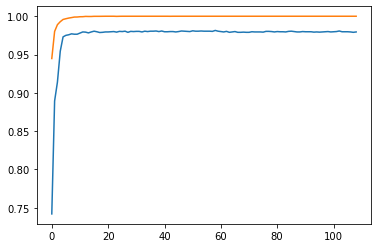

In [345]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.show()

In [346]:
siamese_net.load_weights('best_model.h5')
y_pred_val = siamese_net.predict([pairValX1,pairValX2])

siamese_net.evaluate([pairValX1,pairValX2], labelVal)

127/127 [==============================] - 1s 10ms/step - loss: 0.0765 - accuracy: 0.9815 0s - loss: 0.0803 - accuracy: 0.


[0.07654169946908951, 0.9814814925193787]

In [347]:
siamese_net.evaluate([pairTestX1,pairTestX2], labelTest)

127/127 [==============================] - 1s 7ms/step - loss: 0.0857 - accuracy: 0.9773


[0.08568112552165985, 0.9772839546203613]

In [348]:
y_pred_tst = siamese_net.predict([pairTestX1,pairTestX2])
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix

roc_auc_score(labelTest, y_pred_tst)

0.9975413504039019

In [349]:
confusion_matrix(labelTest, y_pred_tst[:]>0.5)
#incorrect 196 -- avarage=3
#incorrect 187 -- avarage=4
#incorrect 184 -- avarage=4 without dens layer


array([[1993,   32],
       [  60, 1965]], dtype=int64)

In [350]:
from sklearn.metrics  import accuracy_score, auc, roc_curve, precision_recall_curve

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 
                        'threshold' : pd.Series(threshold, index=i),
                       'tpr':pd.Series(tpr, index=i),
                        'fpr':pd.Series(fpr, index=i),
                        'tnr' : pd.Series((1-fpr), index=i),
                        's' : pd.Series((1-fpr) + tpr, index=i),
                        

                        
                       })
    #return roc
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return roc_t['threshold'].values[0], roc_t['tpr'].values[0],roc_t['tnr'].values[0],roc_t['fpr'].values[0] 



In [351]:
#A simpler implementation of the J statistic

def get_optimal_threshold(y_pred, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    # calculate the the Youden’s J statistic
    J = tpr - fpr
        
    # locate the index of the largest g-mean
    ix = np.argmax(J)
    print('Best Threshold=%f' % (thresholds[ix]))
    return thresholds[ix]


In [352]:
#cutoff = get_optimal_threshold( y_pred_tst,labelTest)
cutoff = get_optimal_threshold(y_pred_val,labelVal)
cutoff

Best Threshold=0.472069


0.4720686

In [353]:
#cutoff=0.5
accuracy_score(labelTest, y_pred_tst>cutoff )
#accuracy_score(labelVal,y_pred_val>cutoff )
#0.8946428571428572 - 32
#0.9014285714285715 - 256
#0.8928571428571429 - 64
#0.8775 without extra Dens layer 
#0.9081481481481481 -- avarage=2
#0.9204 -- avarage=3
#0.922 -- avarage=4
#0.920 -- avarage=4 without dens layer
#0.925 -- avarage=4 without dens layer + batchnor
#0.9224 -- avarage=3 without dens layer + batchnor


0.9777777777777777

In [354]:
confusion_matrix(labelTest, y_pred_tst>cutoff)
#array([[1364,   36],  --32
#       [ 254, 1146]], dtype=int64)

#array([[1340,   60],  -256
#       [ 216, 1184]], dtype=int64)
#incorrect 248 -- > avarage=2
#incorrect 199 -- > avarage=3
#incorrect 170 -- > avarage=4
#incorrect 196 -- > avarage=4 without dens layer
#incorrect 196 -- > avarage=4 without dens layer + batchnor
#incorrect 196 -- > avarage=3 without dens layer + batchnor
#incorrect 194 -- > avarage=4 without dens layer + batchnor
#incorrect 227 -- > avarage=2 without dens layer + batchnor


array([[1993,   32],
       [  58, 1967]], dtype=int64)

In [355]:
test_pd = pd.DataFrame()
indexTrue = (labelTest == (y_pred_tst>cutoff) ) # True in case correct and False in case incorrect  

test_pd['Correct'] = indexTrue[:,0]
test_pd['P1']= pairPersonsTest[:,0]
test_pd['P2']= pairPersonsTest[:,1]
test_pd['Same']= (test_pd.P1 ==test_pd.P2 ) # same person or not
test_pd.to_csv('test_cases.csv')

#test_pd[test_pd.Correct==False].groupby(['P1','P2']).count().to_csv('incorrect_cases.csv')
#test_pd.groupby(['P1','Same']).agg(['sum', 'count']).to_csv('all_cases.csv')

testPivot = pd.pivot_table(test_pd, index=["P1"], columns=["Same"], values=["Correct","P1"], aggfunc=[np.sum,np.size])
#testPivot[ [( 'sum', 'Correct', False), ( 'sum', 'Correct', True),( 'size', 'Correct', False) ,( 'size', 'Correct', True)  ]]

test_result_pd= pd.DataFrame()

test_result_pd['P']= testPivot.index
test_result_pd['Same_Rate(TP)'] = list(testPivot[( 'sum', 'Correct', True)] /testPivot[( 'size', 'Correct', True)])
test_result_pd['Diff_Rate(TN)'] = list(testPivot[( 'sum', 'Correct', False)] /testPivot[( 'size', 'Correct', False)])

test_result_pd.to_csv('test_detail_results.csv')
test_result_pd.head()

,P,Same_Rate(TP),Diff_Rate(TN)
0,255,0.955556,0.977778
1,256,0.911111,1.000000
2,257,1.000000,0.977778
3,258,1.000000,1.000000
4,259,1.000000,1.000000


In [356]:
test_result_pd['Same_Rate(TP)'].mean(), test_result_pd['Diff_Rate(TN)'].mean() ,(test_result_pd['Same_Rate(TP)'].mean()+ test_result_pd['Diff_Rate(TN)'].mean() )/2 
#('Same_Rate(TP) , Diff_Rate(TN) , Avarage Accurecy 
#(0.8457142857142855, 0.9571428571428575) - 256
#(0.8199999999999998, 0.965714285714286) - 512
#(0.8349999999999997, 0.92, 0.8775) without extra Dens layer 
#(0.8422222222222223, 0.9740740740740738, 0.908148148148148) --> avarage =2
#(0.8543999999999999, 0.9864000000000003, 0.9204000000000001) --> avarage =3
#(0.8772727272727272, 0.9681818181818178, 0.9227272727272725) --> avarage =4
#(0.8809090909090911, 0.9409090909090908, 0.9109090909090909) --> avarage =4 without dens layer
#(0.8736363636363638, 0.978181818181818, 0.9259090909090909) --> avarage Pics =4 without dens layer +BN
#(0.8632000000000002, 0.9816000000000003, 0.9224000000000002)--> avarage Pics=3 without dens layer +BN
#(0.8874074074074074, 0.9444444444444443, 0.9159259259259258)--> avarage Pics=2 without dens layer +BN

(0.971358024691358, 0.9841975308641975, 0.9777777777777777)

In [357]:
test_result_pd.sort_values('Same_Rate(TP)').head(10) # 7 -->avg-3

,P,Same_Rate(TP),Diff_Rate(TN)
12,267,0.622222,0.955556
34,289,0.777778,0.977778
43,298,0.866667,0.977778
22,277,0.911111,1.000000
1,256,0.911111,1.000000
33,288,0.933333,1.000000
42,297,0.955556,1.000000
17,272,0.955556,1.000000
16,271,0.955556,1.000000
13,268,0.955556,1.000000


In [358]:
test_result_pd.sort_values('Diff_Rate(TN)').head(10)

,P,Same_Rate(TP),Diff_Rate(TN)
27,282,1.000000,0.800000
23,278,1.000000,0.911111
11,266,1.000000,0.933333
12,267,0.622222,0.955556
30,285,1.000000,0.955556
35,290,1.000000,0.955556
25,280,1.000000,0.955556
6,261,1.000000,0.955556
0,255,0.955556,0.977778
43,298,0.866667,0.977778


In [359]:
import numpy
import xlsxwriter
def compute_eer(y_pred, y_true):
    """ Returns equal error rate (EER) and the corresponding threshold. """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    #FAR means fpr 
    #FRR means fnr
    #GAR means tpr
    fnr = 1-tpr
    plt.plot(fnr)
    plt.plot(fpr)
    plt.show()
    print("FAR")
    print(fpr)
    with xlsxwriter.Workbook('FAR.xlsx') as workbook:
        worksheet = workbook.add_worksheet()
        worksheet.write_row(0, 0, fpr)
    
    print("GAR")
    with xlsxwriter.Workbook('GAR.xlsx') as workbook:
        worksheet = workbook.add_worksheet()
        worksheet.write_row(0, 0, tpr)
    print(tpr)
    abs_diffs = np.abs(fpr - fnr)
    min_index = np.argmin(abs_diffs)
    eer = np.mean((fpr[min_index], fnr[min_index]))
    # plot GAR VS FAR
    #plt.plot(fpr)
    #plt.plot(tpr)
    #plt.show()
    return eer, thresholds[min_index], fpr[min_index], fnr[min_index]

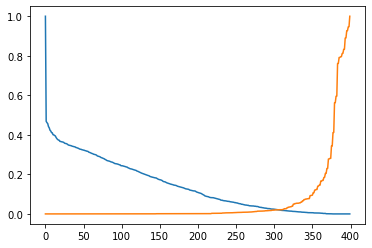

FAR
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00

(0.020740740740740733, 0.28377038, 0.02074074074074074, 0.020740740740740726)

In [360]:
compute_eer(y_pred_tst,labelTest)